# CSC_5RO15_TA_TP1: Direct and Inverse Kinematics

## Introduction

We propose to study the __geometric__ and __kinematic__ modeling of a manipulator arm developed by the *Interactive Robotics Laboratory* of the *CEA List*.

This robot, which kinematic chain is of serial type, has $6$ revolute joints $j_i$ with $i=1,\ldots,6$.

<img 
	style="display: block; 
		margin-left: auto;
		margin-right: auto;"
	src="Images/VueRobot.png"
	width="400">
</img>

The numerical values of the robot parameters, required for the completion of this tutorial, are specified in the following table.

$$
\begin{aligned}
	&\begin{array}{cccc}
	\hline
		\text{Parameters} &	\text{Values} &	\text{Type} \\ 
		\hline
		d_3 & 0.7 m & \text{Geometric parameter} \\
		r_1 & 0.5 m & \text{Geometric parameter} \\
		r_4 & 0.2 m & \text{Geometric parameter} \\
		r_E & 0.1 m & \text{Geometric parameter} \\
	\hline
	\end{array}
\end{aligned}
$$

The use of `python` is required to perform the tutorial. Please import the following required mathematical libraires to start the tutorial:

In [457]:
import matplotlib.pyplot as plt
import numpy as np

In the following, you will progressively update a *Dictionnary* in Python containing the robot parameters, named `robotParameters`.

In [458]:
robotParameters = {
    'nJoints': 6,
    'jointsType': ['R','R','R','R','R','R']
}

You will also progressively build a `class` containing some attributes related to the robot. To do so, you will be asked to program some of its methods in the tutorial. This class is named `RobotModel` and is defined in the file `ClassRobotModel`.

Please initialize it as follows. You will see printing the resulting attributes of the class `RobotModel`.

In [459]:
from ClassRobotModel import RobotModel

RobotTutorials = RobotModel(**robotParameters)

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]


### Utils Functions

In [460]:
def display_array(array: np.ndarray[float], title: str, formating: bool = False) -> None:
    """
    Display an array formatted.

    Args:
        - array (np.ndarray[float]): array to display.
        - title (str): title of the array.
        - formating (bool): if True, add a line before array.
    """
    if formating:
        print("\n")

    if array.ndim == 1:
        line = f"{title}" + " " * (20 - len(title))

        for i in range(len(array)):
            line += f" | {array[i]:+.4f}"

        print(f'{line} |')

    else:
        for i in range(len(array)):
            line = f"{title}" + " " * (20 - len(title))

            for j in range(len(array[i])):
                line += f" | {array[i][j]:+.4f}"

            print(f'{line} |')

In [461]:
def plot_coordinates(
        discrete_time: np.ndarray[float],
        list_q_d_k: np.ndarray[float],
        values_IKM: np.ndarray[float]
    ) -> None:
    """
    Display 3D coordinates errors overall by coordinate.

    Args:
        - discrete_time (np.ndarray[flaot]): time discretezation.
        - list_q_d_k (np.ndarray[float]): list of joint configurations.
        - values_IKM (np.ndarray[float]): list of Inverse Kinematic Module values.
    """
    values_DGM_array = []
    for q_d_k in list_q_d_k:
        RobotTutorials.ComputeDGM(q_d_k)
        RobotTutorials.ComputeToolPose()

        values_DGM_array.append(RobotTutorials.g_0E[0:3, 3])

    values_DGM = np.array(values_DGM_array)

    errors = []
    for value_DGM, value_IKM in zip(values_DGM, values_IKM):
        errors.append(np.linalg.norm(value_IKM - value_DGM))


    fig = plt.figure(figsize=(12, 8))

    ax_left = plt.subplot2grid((6, 6), (0, 0), rowspan=6, colspan=3)
    ax_left.plot(discrete_time, errors)
    ax_left.set_title("overall error")
    ax_left.set_xlabel("time [s]")
    ax_left.set_ylim([1e-30, 1e-6])
    ax_left.set_yscale("log")
    ax_left.grid(True)


    for i, label in enumerate(["X", "Y", "Z"]):
        axis = plt.subplot2grid((6, 6), (0 + 2*i, 3), rowspan=2, colspan=2)
        axis.plot(discrete_time, values_IKM[:, i] - values_DGM[:, i], label=label)

        if i == 0:
            axis.set_title("coordinates errors")

        if i == 2:
            axis.set_xlabel("time [s]")

        axis.set_ylim([1e-30, 1e-6])
        axis.set_yscale("log")
        axis.legend(loc="upper left")
        axis.grid(True)

    plt.tight_layout()
    plt.show()


In [462]:
def plot_limits(
        discrete_time: np.ndarray[float],
        joints_variables: np.ndarray[float],
        q_min: np.ndarray[float],
        q_max: np.ndarray[float],
    ) -> None:
    """
    Display joints evolution with respect to their respective limits.

    Args:
        - discrete_time (np.ndarray[flaot]): time discretezation.
        - joints_variables (np.ndarray[float]): list of joint configurations.
        - q_min (np.ndarray[float]): list of inferior joint limits.
        - q_max (np.ndarray[float]): list of superior joint limits.
    """
    plt.figure(figsize=(8, 16))

    for i in range(6):
        plt.subplot(6, 1, i+1)
        plt.plot(discrete_time, joints_variables[i], label=f'q_{i+1}')
        plt.axhline(y=q_min[i], color='r', linestyle='--', label='q_min' if i == 0 else "")
        plt.axhline(y=q_max[i], color='g', linestyle='--', label='q_max' if i == 0 else "")

        if i == 5:
            plt.xlabel('time [s]')

        plt.yticks([
            -4*np.pi/4, -3*np.pi/4, -2*np.pi/4, -1*np.pi/4, 0,
            +1*np.pi/4, +2*np.pi/4, +3*np.pi/4, +4*np.pi/4]
        )
        plt.xlim([0, 1.4])
        plt.ylim([-np.pi - 0.1, +np.pi + 0.1])
        plt.ylabel(f'q_{i+1} [rad]')
        plt.legend(loc="upper left")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

## DGM, Direct Geometric Model

### Q1

##### Question

Fill in the following figure giving the frames attached to the successive links of the robot according to the *Modified Denavit-Hartenberg (MDH)* parameters defining the spatial arrangement of the robot structure: axis names and geometric distances should be reported on the completed Figure.

<img
    style=  "display: block;
            margin-left: auto;
            margin-right: auto;"
    src="Images/ParametresDH.png"
    width="600">
</img>

##### Answer

From pages 93 and 94 of the Interactive Robotic Systems book the references according to the *Modified Denavit-Hartenberg (MDH)* are presented below:

<img
    style=  "display: block;
            margin-left: auto;
            margin-right: auto;"
    src="Images/ParametresDH_updated.png"
    width="600">
</img>

### Q2.

##### Question

To fill the following table saved on file named `DHM_parameters.txt` in the current repository with the geometric parameters of the robot:

$$
\begin{array}{ccccc}
		\hline
		\hline
		 i  & \alpha_i & d_i & \theta_i & r_i \\
		\hline
		\hline
		1  & ? & ? & ? & ? \\
		\hline
		2  & ? & ? & ? & ? \\
		\hline
		3  & ? & ? & ? & ? \\
		\hline
		4  & ? & ? & ? & ? \\
		\hline
		5  & ? & ? & ? & ? \\
		\hline
		6  & ? & ? & ? & ? \\
		\hline
		\hline
\end{array}
$$

##### Answer

From page 95 the Interactive Robotic Systems book the geometric parameters of the robot are presented below

$$
\begin{array}{ccccc}
		 i  & \alpha_i & d_i & \theta_i & r_i \\
		\hline
		\hline
		1  & 0 & 0 & 0 & 0.5 \\
		\hline
		2  & +\pi/2 & 0 & 0 & 0 \\
		\hline
		3  & 0 & 0.7 & +\pi/2 & 0 \\
		\hline
		4  & +\pi/2 & 0 & 0 & 0.2 \\
		\hline
		5  & -\pi/2 & 0 & 0 & 0 \\
		\hline
		6  & +\pi/2 & 0 & 0 & 0 \\
\end{array}
$$

Then, update the dictionnary `robotParameters` with the DHM parameters as follows:

In [463]:
robotParameters['fileDHM'] = "DHM_parameters.txt"
RobotTutorials = RobotModel(**robotParameters)

display_array(np.array(RobotTutorials.tableDHM), "DHM", formating=True)

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]


DHM                  | +1.0000 | +0.0000 | +0.0000 | +0.0000 | +0.5000 |
DHM                  | +2.0000 | +1.5708 | +0.0000 | +0.0000 | +0.0000 |
DHM                  | +3.0000 | +0.0000 | +0.7000 | +1.5708 | +0.0000 |
DHM                  | +4.0000 | +1.5708 | +0.0000 | +0.0000 | +0.2000 |
DHM                  | +5.0000 | -1.5708 | +0.0000 | +0.0000 | +0.0000 |
DHM                  | +6.0000 | +1.5708 | +0.0000 | +0.0000 | +0.0000 |


### Q3.

#### Q3a.

##### Question

Write a generic function `TransformMatElem`$(\alpha, d, \theta, r)$ which output argument is the homogeneous transform matrix *g* between two successive frames.

##### Answer

In [464]:
@staticmethod
def TransformMatElem(alpha: float, d: float, theta: float, r: float) -> np.ndarray[float]:
    """
    Return Homogeneous Transformation Matrix g as np.ndarray[float] between 2 frames i-1 and i.

    Args:
        alpha (float): angle in radians between z_(i-1) and z_i around x_i
        d (float): distance along z_(i-1) from frame i-1 to frame i
        theta (float): angle in radians between x_(i-1) and x_i around z_(i-1)
        r (float): distance along x_i from frame i-1 to frame i
    """
    # Rotation matrix
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta) * np.cos(alpha), np.cos(theta) * np.cos(alpha), -np.sin(alpha)],
        [np.sin(theta) * np.sin(alpha), np.cos(theta) * np.sin(alpha), np.cos(alpha)]
    ])

    # Translation vector
    p = np.array([d, -r * np.sin(alpha), r * np.cos(alpha)])

    # Homogeneous Transformation Matrix
    g = np.eye(4)
    g[:3, :3] = R
    g[:3, 3] = p

    return g

RobotModel.TransformMatElem = TransformMatElem

From page 96 of the Interactive Robotic Systems book the function above was implemented.
$$
g_{4\times 4} = \begin{bmatrix}
R_{3\times 3} & p_{3\times 1}\\
0_{1\times 3} & 1_{1\times 1}\\
\end{bmatrix}
\qquad\text{where}\quad
\begin{cases}
R_{3\times 3}, & \text{rotation matrix}\\
p_{3\times 3}, & \text{translation matrix}
\end{cases}
$$

#### Q3b.

##### Question

Write a function `ComputeDGM(self, q)` which computes the direct geometric model of any robot with series open kinematic chain, taking as input arguments the current configuration.

##### Answer

In [465]:
def ComputeDGM(self, joints: np.ndarray[float]) -> None:
   """
   Compute the Direct Geometric Model (DGM) given its MDH parameters for the joints configuration.

   Args:
      - joints (np.ndarray[float]): joints configuration.
   """
   # Homogeneous Transformation Matrices between frames i-1 and i
   self.list_g_i_1_i = []

   for i, alpha, d, theta, r in self.tableDHM:
      self.list_g_i_1_i.append(self.TransformMatElem(alpha, d, theta + joints[int(i)-1], r))

   # Direct Geometric Model between frame 0 and i
   self.list_g_0i = [self.list_g_i_1_i[0]]

   for g_i_1_i in self.list_g_i_1_i[1:]:
      self.list_g_0i.append(self.list_g_0i[-1] @ g_i_1_i)

RobotModel.ComputeDGM = ComputeDGM

From page 97 of the Interactive Robotic Systems book the function above was implemented.

#### Q3c.

##### Question

We consider an end-effector mounted at the end of the robot arm. The frame $\mathcal{R}_E$ attached to the end-effector of the robot is defined by a translation of the frame  $\mathcal{R}_6$ by a distance $r_E$ along the $z_6$ axis.

Specify the four DHM parameters for the tool frame description in the field below.


In [466]:
robotParameters['toolFrameDHM'] = [0, 0, 0, 0.1]
RobotTutorials = RobotModel(**robotParameters)

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]
Attribute (list - float): self.toolDHM =  [0, 0, 0, 0.1]


Using the results of previous questions, write a function `ComputeToolPose(self)` that computes the homogeneous transform matrix $\overline{g}_{0E}$. This matrix gives the position and the orientation of the frame $\mathcal{R}_E$ attached to the end-effector of the robot, expressed in the base frame $\mathcal{R}_0$.

##### Answer

In [467]:
def ComputeToolPose(self) -> None:
   """
   Compute the Homogeneous Transform Matrix between frame 0 and E.
   """
   alpha, d, theta, r = self.toolDHM

   # Homogeneous Transformation Matrix between frame 0 and E
   self.g_0E = self.list_g_0i[-1] @ self.TransformMatElem(alpha, d, theta, r)

RobotModel.ComputeToolPose = ComputeToolPose

From page 97 of the Interactive Robotic Systems book the function above was implemented.

In the following, we consider two joint configurations $q=\left[q_1, \ldots, q_6\right]^t$ of the robot:
- $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$
- $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$

Indicate what are the homogeneous transform matrices $\overline{g}_{0E}$ evaluated in these two confugrations.

In [468]:
q_i = [-np.pi/2, 0, -np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2]
display_array(np.array(q_i), "q_i")

q_i                  | -1.5708 | +0.0000 | -1.5708 | -1.5708 | -1.5708 | -1.5708 |


In [469]:
RobotTutorials.ComputeDGM(q_i)
RobotTutorials.ComputeToolPose()
display_array(RobotTutorials.g_0E, "q_i:")

q_i:                 | -0.0000 | -0.0000 | -1.0000 | -0.1000 |
q_i:                 | +1.0000 | -0.0000 | -0.0000 | -0.7000 |
q_i:                 | -0.0000 | -1.0000 | +0.0000 | +0.3000 |
q_i:                 | +0.0000 | +0.0000 | +0.0000 | +1.0000 |


In [470]:
q_f = [0, np.pi/4, 0, np.pi/2, np.pi/2, 0]
display_array(np.array(q_f), "q_f")

q_f                  | +0.0000 | +0.7854 | +0.0000 | +1.5708 | +1.5708 | +0.0000 |


In [471]:
RobotTutorials.ComputeDGM(q_f)
RobotTutorials.ComputeToolPose()
display_array(RobotTutorials.g_0E, "q_f:")

q_f:                 | -0.7071 | +0.7071 | +0.0000 | +0.6364 |
q_f:                 | -0.0000 | -0.0000 | -1.0000 | -0.1000 |
q_f:                 | -0.7071 | -0.7071 | +0.0000 | +1.1364 |
q_f:                 | +0.0000 | +0.0000 | +0.0000 | +1.0000 |


### Q4.

##### Question

What are the values of positions $P_x, P_y, P_z$ and the parameters related to the orientation $R_{n,q}$ ($n$ being the direction vector and $q \in \left[0,\pi\right]$ the rotation angle such that $R_{n,q}=R_{0E}$) of the end-effector frame for the two joint configurations $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$ and $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$ ($q=\left[q_1, \ldots, q_6\right]^t$)?

To do so, write a function `DescribeToolFrame(self)` that computes the position vector and the parameters related to the orientation of the end-effector frame for the current configuration.

##### Answer

In [472]:
def DescribeToolFrame(self) -> None:
        """Retrieve the angle and axis of rotation of the end-effector frame."""
        # Rotation Matrix
        R = self.g_0E[0:3,0:3]

        r11, r12, r13 = R[0]
        r21, r22, r23 = R[1]
        r31, r32, r33 = R[2]

        # Angle of Rotation
        theta = np.atan2(
                1/2 * np.sqrt((r32 - r23)**2 + (r13 - r31)**2 + (r21 - r12)**2),
                1/2 * (r11 + r22 + r33 - 1)
        )

        # Axis of Rotation
        if np.sin(theta) != 0:
                w = np.array([
                        (r32 - r23)/(2 * np.sin(theta)),
                        (r13 - r31)/(2 * np.sin(theta)),
                        (r21 - r12)/(2 * np.sin(theta))
                ])
        else:
                w = np.array([0, 0, 0])

        # Position of the end-effector frame
        self.p_E = self.g_0E[0:3, 3]
        self.w_E = w
        self.theta_E = theta

RobotModel.DescribeToolFrame = DescribeToolFrame

From pages 60 and 61 of the Interactive Robotic Systems book the function above was implemented.

In [473]:
RobotTutorials.ComputeDGM(q_i)
RobotTutorials.ComputeToolPose()
RobotTutorials.DescribeToolFrame()
display_array(RobotTutorials.p_E, "q_i: P", )
display_array(RobotTutorials.w_E, "q_i: n")
print(f"q_i: q = {RobotTutorials.theta_E:.4f}")

q_i: P               | -0.1000 | -0.7000 | +0.3000 |
q_i: n               | -0.5774 | -0.5774 | +0.5774 |
q_i: q = 2.0944


In [474]:
RobotTutorials.ComputeDGM(q_f)
RobotTutorials.ComputeToolPose()
RobotTutorials.DescribeToolFrame()
display_array(RobotTutorials.p_E, "q_f: P")
display_array(RobotTutorials.w_E, "q_f: n")
print(f"q_f: q = {RobotTutorials.theta_E:.4f}")

q_f: P               | +0.6364 | -0.1000 | +1.1364 |
q_f: n               | +0.2811 | +0.6786 | -0.6786 |
q_f: q = 2.5936


## DKM, Direct Kinematic Model

### Q5.

##### Question

Write a function `ComputeJac(self, q)` which output is the Jacobian matrix ${}^0J(q)$ (computed by the method of velocities composition).

Reminder: the Jacobian matrix relates the velocities in the task coordinates of the end-effector frame in $\mathcal{R}_0$, for a given joint configuration $q$, to the joint velocities:
\begin{align*}
{}^0\mathcal{V}_{0,E}&= \begin{bmatrix}^0V_{0,E}\left(O_E\right) \\ ^0\omega_{0,E} \end{bmatrix} = \begin{bmatrix} {}^0J_v \left(q\right)  \\ {}^0J_{\omega} \left(q\right)\end{bmatrix} \dot{q} = {}^0J\left(q\right) \dot{q}
\end{align*}

##### Answer

In [475]:
def ComputeJac(self, joints: np.ndarray[float]) -> None:
   """
   Compute the Jacobian matrix mapping the joint velocities to the velocities of the end-effector
   for a joint configuration "joints".

   Args:
      - joints (np.ndarray[float]): joints configuration.
   """
   # Update the DGM and the tool pose
   self.ComputeDGM(joints)
   self.ComputeToolPose()
   self.DescribeToolFrame()

   z_i = np.array([0, 0, 1]).T
   p_0E = self.g_0E[0:3, 3]

   self.oJ = np.zeros((6, self.numberJoints))

   for i in range(self.numberJoints):
      R_0i = self.list_g_0i[i][0:3, 0:3]
      p_0i = self.list_g_0i[i][0:3, 3]

      p_iE = p_0E - p_0i

      # Rotation Joint
      if self.jointsType[i] == 'R':
         self.oJ[0:3, i] = np.cross(R_0i.dot(z_i), p_iE)
         self.oJ[3:6, i] = R_0i.dot(z_i)

      # Prismatic Joint
      elif self.jointsType[i] == 'P':
         self.oJ[0:3, i] = R_0i.dot(z_i)
         self.oJ[3:6, i] = np.array([[0], [0], [0]])

RobotModel.ComputeJac = ComputeJac

From page 104 of the Interactive Robotic Systems book: according to **Khalil-Kleinfinger** convention, the jointe axis is along the vector $Z_{i} = [0\;0\;1]^{\intercal}$.

From page 107 of the Interactive Robotic Systems book: equations are implemented above was done. Based on the **Khalil-Kleinfinger** notation was simplified.

What are the values of the twists at $O_E$ evaluated with $q=q_i$ and $q=q_f$ with the joint velocities $\dot q = \left[0.5, 1.0, -0.5, 0.5, 1.0, -0.5\right]^t$?

In [476]:
q_dot = np.array([+0.5, +1.0, -0.5, +0.5, +1.0, -0.5]).T
display_array(q_dot, "q_dot:")

q_dot:               | +0.5000 | +1.0000 | -0.5000 | +0.5000 | +1.0000 | -0.5000 |


In [477]:
RobotTutorials.ComputeJac(q_i)
display_array(RobotTutorials.oJ, "q_i: J")
display_array(RobotTutorials.oJ @ q_dot, "q_i: J * q_dot", formating=True)

q_i: J               | +0.7000 | +0.0000 | +0.0000 | +0.0000 | +0.0000 | -0.0000 |
q_i: J               | -0.1000 | -0.2000 | -0.2000 | +0.1000 | +0.0000 | -0.0000 |
q_i: J               | +0.0000 | +0.7000 | -0.0000 | -0.0000 | -0.1000 | -0.0000 |
q_i: J               | +0.0000 | -1.0000 | -1.0000 | -0.0000 | -0.0000 | -1.0000 |
q_i: J               | +0.0000 | -0.0000 | -0.0000 | -0.0000 | -1.0000 | -0.0000 |
q_i: J               | +1.0000 | +0.0000 | +0.0000 | -1.0000 | -0.0000 | +0.0000 |


q_i: J * q_dot       | +0.3500 | -0.1000 | +0.6000 | +0.0000 | -1.0000 | -0.0000 |


In [478]:
RobotTutorials.ComputeJac(q_f)
display_array(RobotTutorials.oJ, "q_f: J")
display_array(RobotTutorials.oJ @ q_dot, "q_f: J * q_dot", formating=True)

q_f: J               | +0.1000 | -0.6364 | -0.1414 | +0.0707 | -0.0707 | +0.0000 |
q_f: J               | +0.6364 | +0.0000 | +0.0000 | +0.0000 | -0.0000 | +0.0000 |
q_f: J               | -0.0000 | +0.6364 | +0.1414 | -0.0707 | -0.0707 | -0.0000 |
q_f: J               | +0.0000 | +0.0000 | +0.0000 | +0.7071 | +0.7071 | +0.0000 |
q_f: J               | +0.0000 | -1.0000 | -1.0000 | -0.0000 | -0.0000 | -1.0000 |
q_f: J               | +1.0000 | +0.0000 | +0.0000 | +0.7071 | -0.7071 | +0.0000 |


q_f: J * q_dot       | -0.5510 | +0.3182 | +0.4596 | +1.0607 | -0.0000 | +0.1464 |


### Q6.

##### Question

In the rest of the study, we restrict the analysis of operational end-effector velocities to translational velocities via ${}^0J_v \left(q\right)$.

Qualify the transmission of velocities between the joint and task spaces for the corresponding $q_i$ and $q_f$ configurations:
- what is the preferred direction to transmit velocity in the task space?
- what are the corresponding velocity manipulabilities?

To help, you can program a function `QualifyVelocityTransmission(self)` that analyses the property of the Jacobian matrix. Explain your results.

##### Answer

In [479]:
def QualifyVelocityTransmission(self) -> None:
   """Analyse Transmission of Velocities from Jacobian matrix."""
   # Jacobian of Translational Velocities
   J_v = self.oJ[0:3, :]

   U, S, _ = np.linalg.svd(J_v) # singular value decomposition

   self.preferredDirection = U[:, 0]
   self.velocityManipulability = np.prod(S)

   self.conditionNumber = np.linalg.cond(J_v)
   self.rank = np.linalg.matrix_rank(J_v)
   self.det = np.linalg.det(J_v @ J_v.T)

RobotModel.QualifyVelocityTransmission = QualifyVelocityTransmission

In [480]:
RobotTutorials.ComputeJac(q_i)
RobotTutorials.QualifyVelocityTransmission()
display_array(RobotTutorials.preferredDirection, "q_i: preferredDirection")
print(f"q_i: velocityManipulability = {RobotTutorials.velocityManipulability:.4f}")

q_i: preferredDirection | +0.3660 | -0.3263 | +0.8715 |
q_i: velocityManipulability = 0.1116


In [481]:
RobotTutorials.ComputeJac(q_f)
RobotTutorials.QualifyVelocityTransmission()
display_array(RobotTutorials.preferredDirection, "q_f: preferredDirection")
print(f"q_f: velocityManipulability = {RobotTutorials.velocityManipulability:.4f}")

q_f: preferredDirection | -0.7114 | -0.0975 | +0.6959 |
q_f: velocityManipulability = 0.0590


From page 110 of the Interactive Robotic Systems book: rank of the jacobian matrix corresponds to the degrees-of-freedom of the robot space associated to the end-effector frame, the dimension of the reachable task space in this particular configuration q.

With that in mind it is possible to see that the $q_{i}$ jacobian has an higher ranking value therefore it's end effector has higher reachable task space.

From page 112 of the Interactive Robotic Systems book: when the determine of the jacobian matrix is zero, it means that the configuration $q$ is a singularity.

From page 116 of the Interactive Robotic Systems book: principal axes of the ellipsoid are given by the eigen vectors and it's volume is an indicator of the robot capacity to generate velocity, velocity manipilability.

With the results obtained `q_i` configuration has a better capacity to generate velocity because it has a higher **velocity manipulability**.

## IGM, Inverse Geometric Model

### Q7.

##### Question

In this study, the resolution of the inverse geometric model is considered numerically by exploiting the inverse differential model. Moreover, the study is restricted to the position only of the robot's end-effector frame in the task space with no constraint on the orientation of the end-effector frame.

Using an iterative procedure exploiting the pseudo-inverse of the Jacobian matrix, program a function `ComputeIGM`$(\text{self}, X_d, q_0, k_{max}, \epsilon_x)$ having as input arguments the desired task position $X_d$ and the initial condition $q_0$.

Both the maximum number of iterations $k_{max}$ of the algorithm and the norm of the tolerated Cartesian error $|X_d - DGM(q_{k})|<\epsilon_x$, define the stopping criteria of the algorithm.

##### Answer

In [482]:
def ComputeIGM(
      self,
      q_0: np.ndarray[float],
      X_d: np.ndarray[float],
      k_max: int = 100,
      X_epsilon: float = 0.001
   ) -> np.ndarray[float]:
   """
   Return the Inverse Geometric Model (IGM) mapping the Cartesian pose to the joints vector q_0.

   Args:
      - q_0 (np.ndarray[float]): initial joints conditions.
      - X_d (np.ndarray[float]): dessired cartesian vectors.
      - k_max (int): iterations maximum.
      - X_epsilon (float): cartesian error threshold.
   """
   self.list_q_IGM = [q_0]
   q_k = q_0

   for _ in range(k_max):
      # Update the DGM and the tool pose
      self.ComputeDGM(q_k)
      self.ComputeToolPose()
      X_k = self.g_0E[0:3, 3]

      self.ComputeJac(q_k)
      J_v = self.oJ[0:3, :]

      q_k = q_k + np.linalg.pinv(J_v) @ (X_d - X_k)
      self.list_q_IGM.append(q_k)

      if np.linalg.norm(X_d - X_k) < X_epsilon:
         break

   return self.list_q_IGM[-1]

RobotModel.ComputeIGM = ComputeIGM

From page 130 of the Interactive Robotics Systems book: an interactive optimization method was implemented considering a cartisian error as stop condition.

Compute $q^{\ast}$ when the function is called with the following arguments:

1. $X_d=X_{d_i}=\left(-0.10, -0.70, +0.30\right)^t$, $q_0=\left[ -1.57, +0.00, -1.47, -1.47, -1.47, -1.47 \right]$, $k_{max}=100$, $\epsilon_x=1$ mm?

1. $X_d=X_{d_f}=\left(+0.64, -0.10, +1.14\right)^t$, $q_0=\left[ +0.00, +0.80, +0.00, +1.00, +2.00, +0.00 \right]$, $k_{max}=100$, $\epsilon_x=1$ mm?

Check the accuracy of the results using the function calculated in __Q3.__

In [483]:
X_di = np.array([-0.10, -0.70, +0.30]).T
q_0i = np.array([-1.57, +0.00, -1.47, -1.47, -1.47, -1.47])

display_array(np.array(q_i), "q_i:")
display_array(RobotTutorials.ComputeIGM(q_0i, X_di), "q_i_IGM:")
display_array(RobotTutorials.g_0E[0:3, 3], "p_i:")
display_array(X_di, "X_di:")
display_array(np.abs(X_di - RobotTutorials.g_0E[0:3, 3]), "error_i:")

q_i:                 | -1.5708 | +0.0000 | -1.5708 | -1.5708 | -1.5708 | -1.5708 |
q_i_IGM:             | -1.5725 | +0.0132 | -1.5232 | -1.4452 | -1.4819 | -1.4700 |
p_i:                 | -0.0999 | -0.7000 | +0.3003 |
X_di:                | -0.1000 | -0.7000 | +0.3000 |
error_i:             | +0.0001 | +0.0000 | +0.0003 |


In [484]:
X_df = np.array([+0.64, -0.10, +1.14]).T
q_0f = np.array([+0.00, +0.80, +0.00, +1.00, +2.00, +0.00])

display_array(np.array(q_f), "q_f:")
display_array(RobotTutorials.ComputeIGM(q_0f, X_df), "q_f_IGM:")
display_array(RobotTutorials.g_0E[0:3, 3], "p_f:")
display_array(X_df, "X_df:")
display_array(np.abs(X_df - RobotTutorials.g_0E[0:3, 3]), "error_f:")

q_f:                 | +0.0000 | +0.7854 | +0.0000 | +1.5708 | +1.5708 | +0.0000 |
q_f_IGM:             | -0.0246 | +0.7643 | -0.1782 | +1.0017 | +1.5693 | +0.0000 |
p_f:                 | +0.6399 | -0.0999 | +1.1399 |
X_df:                | +0.6400 | -0.1000 | +1.1400 |
error_f:             | +0.0001 | +0.0001 | +0.0001 |


## IKM, Inverse Kinematic Model

In this question, the trajectory of the end-effector to be followed in the task space must allow the desired final position $X_{d_f}$ to be reached by following a straight line in the task space starting at the initial position $X_{d_i}$.

This rectilinear motion is carried out at a constant speed $V=1m.s^{-1}$ and is sampled at a period $T_e=1$ ms. The position of the end effector at the time instant $kT_e$ is noted $X_{d_k}$. The initial configuration of the robot is given by $q_i$ (found in question __Q4.__).

### Q8.

Using the inverse differential kinematic model, write a function entitled `ComputeIKM`$( \text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i)$ realizing the coordinate transform to provide the series of setpoint values $q_{d_k}$ corresponding to the $X_{d_k}$ to the joint drivers.

#### Q8a.

##### Question

To do this, after having programmed the time law corresponding to the required motion, you can use the function developed in question __Q7__ capable of calculating the iterative MGI from the pseudo-inverse of the Jacobian matrix.

##### Answer

In [485]:
def ComputeIKM(
        self,
        q_0: np.ndarray[float],
        X_d_i: np.ndarray[float],
        X_d_f: np.ndarray[float],
        speed: float,
        period: float,
        k_max: int = 100,
        X_epsilon: float = 0.001
    ) -> None:
    """
    Compute of the Inverse Kinematic Model (IKM) making the coordinate transform to provide
    the series of setpoint values q_d_k corresponding to the X_d_k to the joint drivers.

    Args:
        - q_0 (np.ndarray[float]): initial joints conditions.
        - X_d_i (np.ndarray[float]): dessired cartesian vectors of initial point.
        - X_d_f (np.ndarray[float]): dessired cartesian vectors of final point.
        - speed (float): linear velocity in m/s.
        - period (float): sample period in 1/s.
        - k_max (int): iterations maximum.
        - X_epsilon (float): cartesian error threshold.
    """
    # Discretization of movement
    distance = np.linalg.norm(X_d_f - X_d_i)
    duration = distance / speed
    steps = int(duration / period)

    self.discreteTime = np.array([k * period for k in range(steps + 1)])
    self.list_X_d_k = [X_d_i + k / steps * (X_d_f - X_d_i) for k in range(steps + 1)]

    # Iterate over discretization
    q_k = q_0
    self.list_q_d_k = []

    for X_d_k in self.list_X_d_k:
        q_k = self.ComputeIGM(q_k, X_d_k, k_max, X_epsilon)
        self.list_q_d_k.append(q_k)

RobotModel.ComputeIKM = ComputeIKM

#### Q8b.

##### Question

Check that the successively reached positions of the end-effector is following the desired trajectory. To do so, you can plot the error between the sequence of positions reached by the end device and the position set points at each time step.

##### Answer

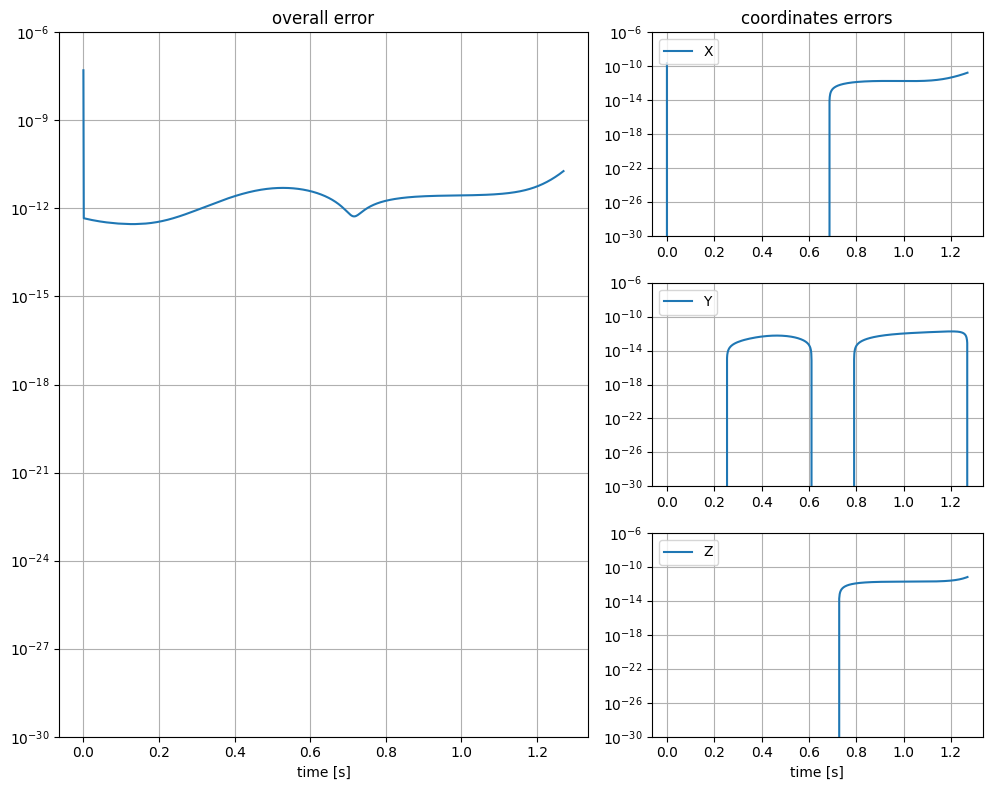

In [486]:
RobotTutorials.ComputeIKM(q_0i, X_di, X_df, speed=1, period=0.001)

plot_coordinates(
    RobotTutorials.discreteTime,
    RobotTutorials.list_q_d_k,
    np.array(RobotTutorials.list_X_d_k)
)

### Q9.

##### Question

Plot the temporal evolution of the joint variables $q_1$ to $q_6$ calculated in the previous question. For each joint variable, graphically overlay the allowable extreme values corresponding to the joint limits:
\begin{align*}
q_{min} = \left[\begin{array}{c}{ -\pi , -\frac{\pi}{2} , -\pi , -\pi , -\frac{\pi}{2}, -\pi }\end{array}\right] 
\end{align*}
and
\begin{align*}
q_{max} = \left[\begin{array}{c}{ 0 , \frac{\pi}{2} , 0  ,\frac{\pi}{2}, \frac{\pi}{2} , \frac{\pi}{2} }\end{array}\right] 
\end{align*}

##### Answer

In [487]:
q_min = np.array([-np.pi, -np.pi/2, -np.pi, -np.pi, -np.pi/2, -np.pi])
q_max = np.array([0, np.pi/2, 0, np.pi/2, np.pi/2, np.pi/2])

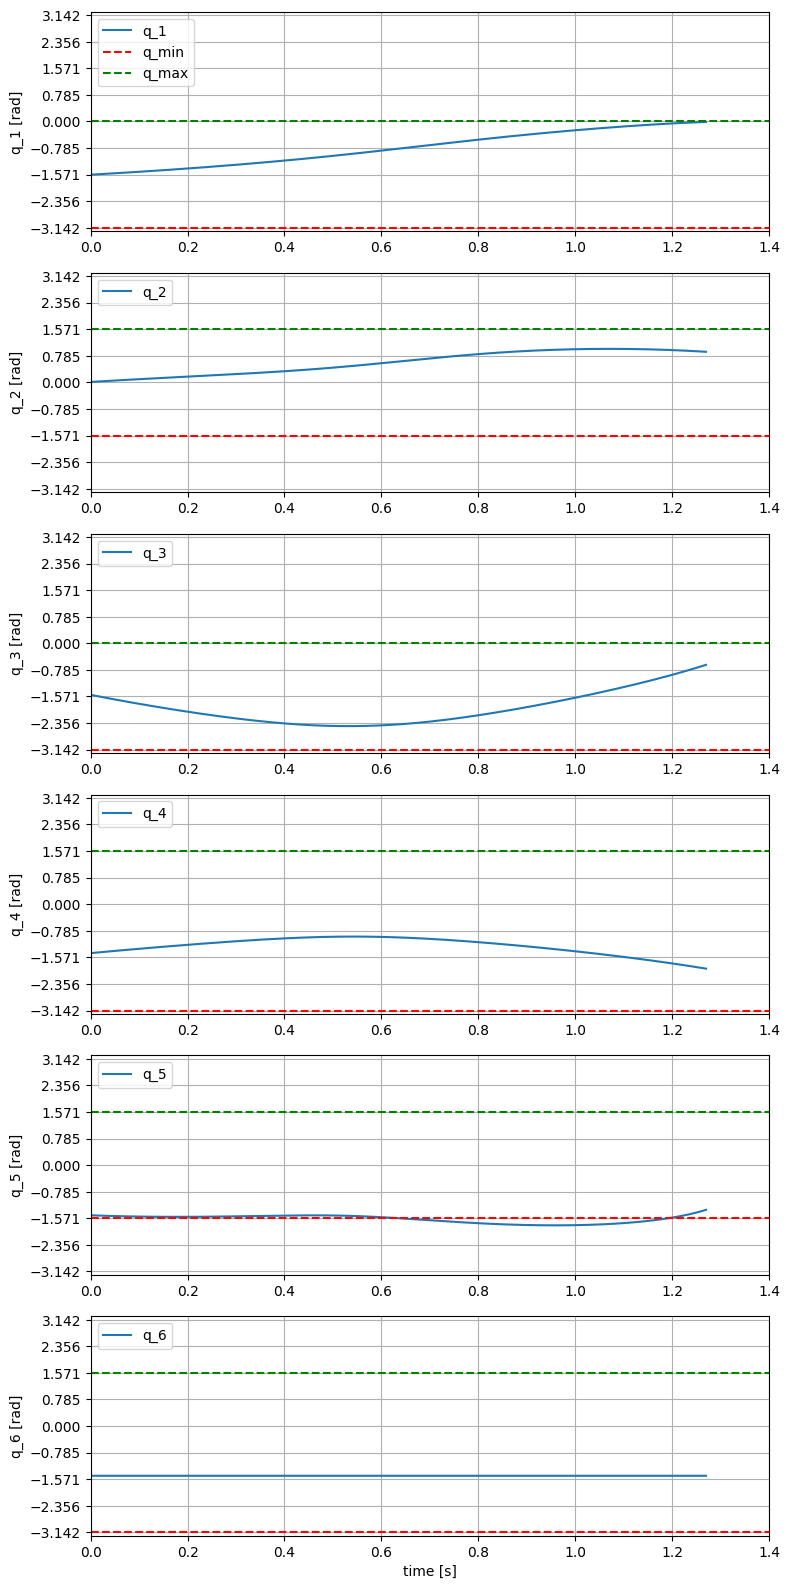

In [488]:
plot_limits(
    RobotTutorials.discreteTime,
    np.array(RobotTutorials.list_q_d_k).T,
    q_min,
    q_max,
)

By what it is shown in the picture above it is visible that most joints respect their limits but `q_5` does not respect it's inferior limit meaning that the trajectory proposed is not feaseable physically by robot.

This is an example on how the `ComputeIKM()` function may provide an impossible trajectory for the robot.

### Q10.

#### Q10a.

##### Question

In this question, we modify the algorithm developed in question __Q8__. We wish to take into account the distance of the values taken by the joint variables from their limits in the computation of the inverse kinematic model.

To do so, you will need to consider a secondary task aiming at keeping some distance from the articular stops $q_{min}$ and $q_{max}$. By the technique of the gradient projected into the null space of ${}^0J_v \left(q\right)$, you will consider minimizing the following potential function:
\begin{align*}
			H_{lim}\left(q\right) = \sum_{i=1}^{n} \left(\frac{q_i-\overline{q}_{i}}{q_{max}-q_{min}}\right)^2 \hspace{0.2cm} \text{where} \hspace{0.2cm} \overline{q}_{i} =  \frac{q_{max}+q_{min}}{2} 
\end{align*}

First, provide below the theoretical analytical solution for the joint variables to this problem.

##### Answer

The theoretical analytical solution for the joint variables to the problem of maintaining a safe distance from the joint limits while following a desired trajectory can be derived by minimizing the potential function $H_{\text{lim}}(q)$. This potential function is defined as:
$$
H_{\text{lim}}(q) = \sum_{i=1}^{n} \left(\frac{q_i - \overline{q}_i}{q_{\text{max, i}} - q_{\text{min, i}}}\right)^2
$$
where $\overline{q}_i = \frac{q_{\text{max, i}} + q_{\text{min, i}}}{2}$ represents the midpoint of the joint limits for the $i$-th joint.

To minimize this potential function, we need to compute its gradient with respect to the joint variables $q$:
$$
\nabla H_{\text{lim}}(q) = \frac{\partial H_{\text{lim}}(q)}{\partial q} = 2 \sum_{i=1}^{n} \frac{q_i - \overline{q}_i}{(q_{\text{max, i}} - q_{\text{min, i}})^2}
$$

This gradient represents the direction in which the potential function increases the most. To ensure that the joint variables stay within the safe limits, we project this gradient into the null space of the Jacobian matrix ${}^0J_v(q)$. The null space projection ensures that the primary task of following the desired trajectory is not disturbed.

The update rule for the joint variables $ q $ at each iteration can be expressed as:
$$
q_{k+1} = q_k + {}^0J_v^{\dagger}(q_k) \epsilon + \left( I - {}^0J_v^{\dagger}(q_k) {}^0J_v(q_k) \right) \nabla H_{lim}(q_k) \Delta t
$$

where:
- $q_k$ is the joint configuration at iteration $k$
- ${}^0J_v^{\dagger}(q_k)$ is the pseudo-inverse of the Jacobian matrix
- $\epsilon$ is the Cartesian error between the desired and current end-effector positions
- $I$ is the identity matrix
- $\Delta t$ is the time step

By iteratively applying this update rule, the joint variables are adjusted to follow the desired trajectory while maintaining a safe distance from the joint limits.

#### Q10b.

##### Question

Then, develop a new function `ComputeIKMlimits`$(\text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i, q_{min}, q_{max})$ which implements the inverse kinematic model able to take into account the previous secondary task.

##### Answer

In [489]:
def ComputeIKMlimits(
        self,
        q_0: np.ndarray[float],
        X_d_i: np.ndarray[float],
        X_d_f: np.ndarray[float],
        speed: float,
        period: float,
        k_max: int,
        x_epsilon: float,
        q_min: np.ndarray[float],
        q_max: np.ndarray[float],
        alpha: float = 0.05
    ) -> None:
    """
    Compute of the Inverse Kinematic Model (IKM) making the coordinate transform to provide
    the series of setpoint values q_d_k corresponding to the X_d_k to the joint drivers considering
    joints limits.

    Args:
        - q_0 (np.ndarray[float]): initial joints conditions.
        - X_d_i (np.ndarray[float]): dessired cartesian vectors of initial point.
        - X_d_f (np.ndarray[float]): dessired cartesian vectors of final point.
        - speed (float): linear velocity in m/s.
        - period (float): sample period in 1/s.
        - k_max (int): iterations maximum.
        - X_epsilon (float): cartesian error threshold.
        - q_min (np.ndarray[float]): list of inferior joint limits.
        - q_max (np.ndarray[float]): list of superior joint limits.
    """
    distance = np.linalg.norm(X_d_f - X_d_i)
    total_time = distance / speed
    num_steps = int(total_time / period)

    self.discreteTime = np.array([k * period for k in range(num_steps + 1)])
    self.list_X_d_k = [X_d_i + k / num_steps * (X_d_f - X_d_i) for k in range(num_steps + 1)]
    self.list_q_d_k_limits = []

    q_mid = (q_max + q_min) / 2

    q_k = q_0
    for X_d_k in self.list_X_d_k:
        for _ in range(k_max):
            self.ComputeDGM(q_k)
            self.ComputeToolPose()

            X_k = self.g_0E[0:3, 3]
            X_d_d = X_d_k - X_k

            self.ComputeJac(q_k)
            J_k = self.oJ[0:3, :]

            grad_H = 2 * (q_k - q_mid) / (q_max - q_min)**2

            J_pinv = np.linalg.pinv(J_k)
            q_0_d = -alpha * grad_H

            q_k = q_k + J_pinv @ X_d_d + (np.eye(len(q_k)) - J_pinv @ J_k) @ q_0_d

            if np.linalg.norm(X_d_d) < x_epsilon:
                break

        self.list_q_d_k_limits.append(q_k)


RobotModel.ComputeIKMlimits = ComputeIKMlimits

From page 137 of the Interactive Robots Systems book: 
From page 135 of the 

Plot the new temporal evolution of the joint variables $q_1$ to $q_6$ for the reference trajectory given in the question __Q9__.

In [490]:
q_min = np.array([-np.pi, -np.pi/2, -np.pi, -np.pi, -np.pi/2, -np.pi])
q_max = np.array([0, np.pi/2, 0, np.pi/2, np.pi/2, np.pi/2])

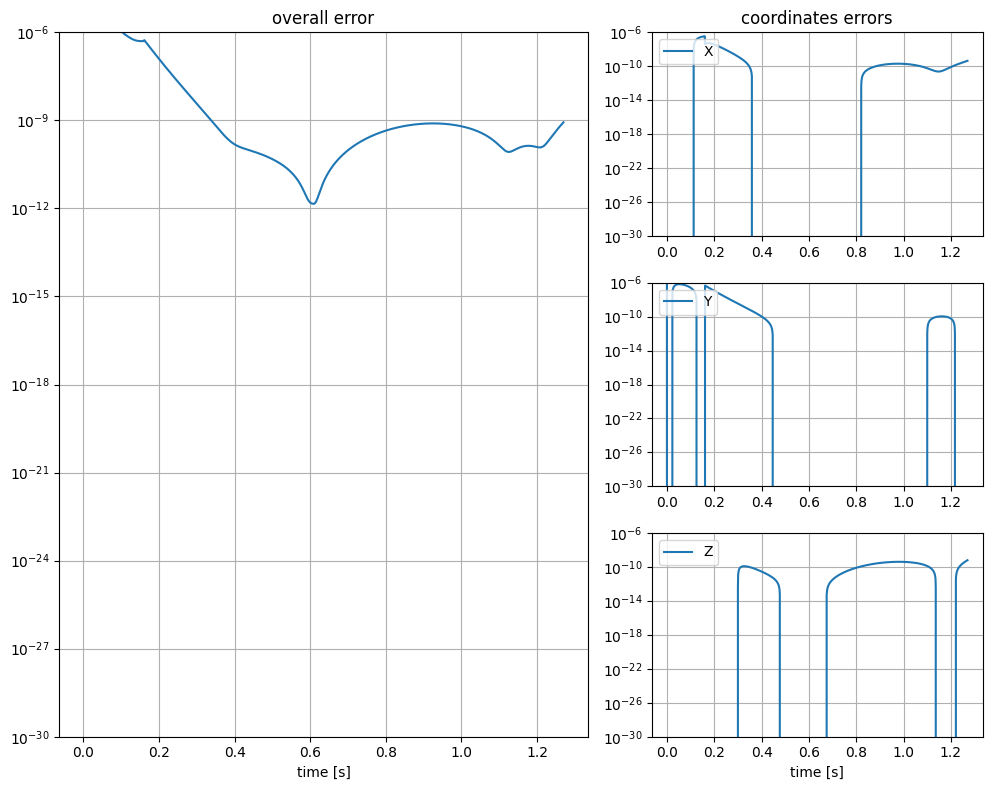

In [491]:
RobotTutorials.ComputeIKMlimits(q_0i, X_di, X_df, speed=1, period=0.001, k_max=100, x_epsilon=0.001, q_min=q_min, q_max=q_max)

plot_coordinates(
    RobotTutorials.discreteTime,
    RobotTutorials.list_q_d_k_limits,
    np.array(RobotTutorials.list_X_d_k)
)

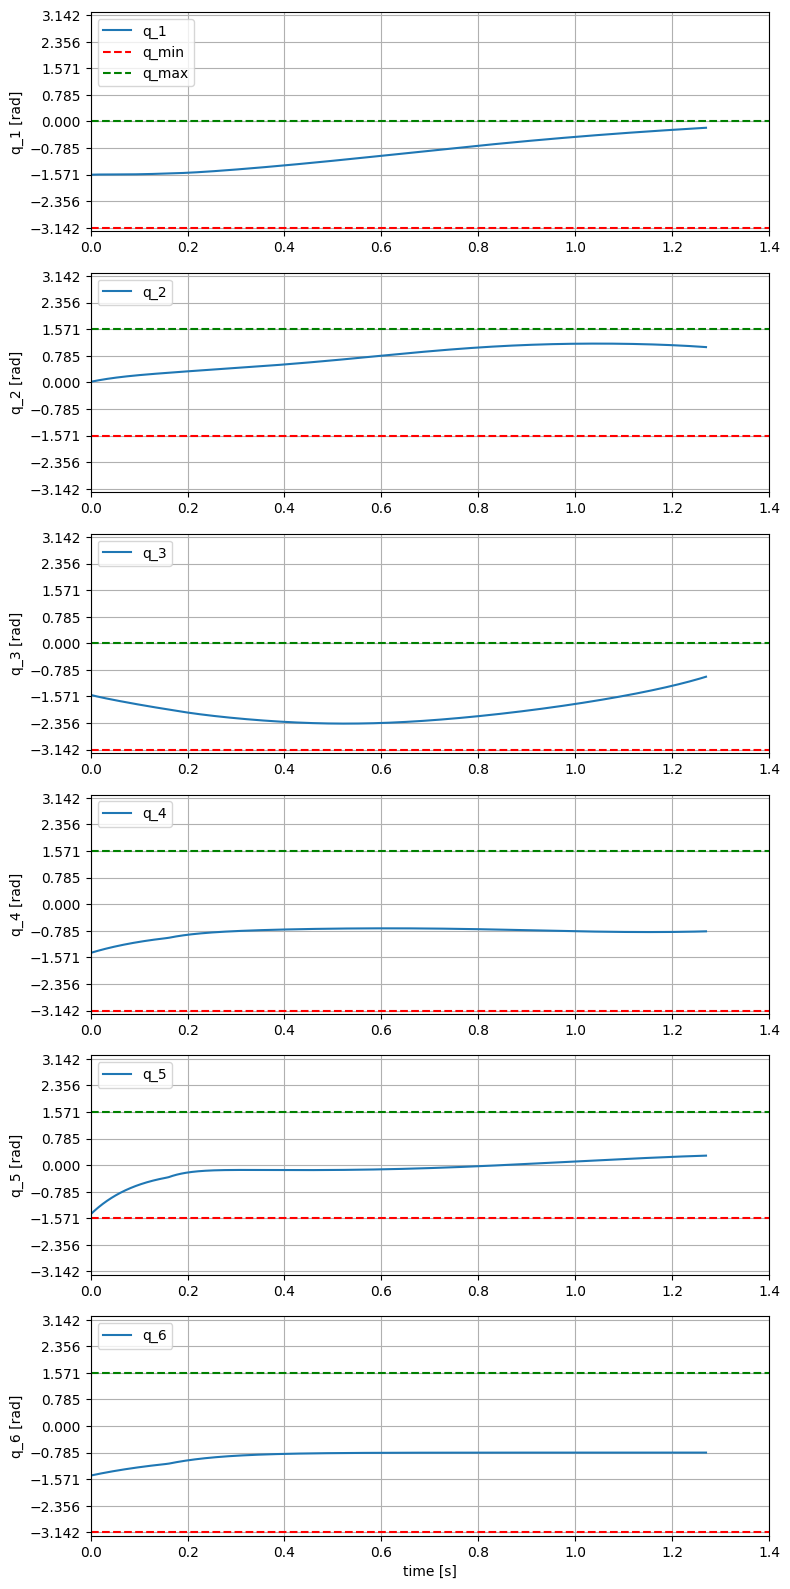

In [492]:
plot_limits(
    RobotTutorials.discreteTime,
    np.array(RobotTutorials.list_q_d_k_limits).T,
    q_min,
    q_max,
)

Now, all joints configurations respect their limits avoid an impossible configuration but that implies an higher error in coordinates estimation which is a fair trade-off between both methods.